# Linear Regression

In [28]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [3]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.04399 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00135 sec'

In [10]:
print(timer.times)

[0.043991804122924805, 0.0013539791107177734]


In [11]:
# Normal distribution
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [15]:
# Visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
plt.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlable='x',
         ylable='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

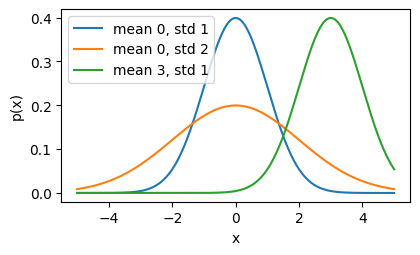

In [14]:
x = np.linspace(-5, 5, 1400)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

plt.figure(figsize=(4.5, 2.5))
for mu, sigma in params:
    plt.plot(x, normal(x, mu, sigma), label=f'mean {mu}, std {sigma}')

plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

In [16]:
import random

In [21]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.9822, -0.0713]) 
label: tensor([2.4910])


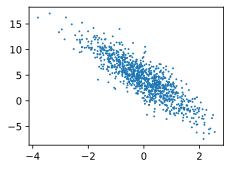

In [29]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [30]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [34]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4673,  1.9285],
        [-0.6682, -2.2272],
        [-0.0539, -0.6749],
        [ 1.0536, -1.6532],
        [-0.4134, -1.6673],
        [ 0.2260,  0.1025],
        [-0.9798,  1.3658],
        [ 1.5016, -1.1937],
        [ 1.7117, -0.0222],
        [-0.0377, -1.0736]]) 
 tensor([[-1.4254],
        [10.4489],
        [ 6.3821],
        [11.9213],
        [ 9.0369],
        [ 4.2976],
        [-2.4088],
        [11.2683],
        [ 7.7036],
        [ 7.7732]])


In [35]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [37]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [38]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [39]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [40]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [41]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031783
epoch 2, loss 0.000105
epoch 3, loss 0.000046


In [42]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


# Concise Implementation of Liner Regression

In [44]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [45]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [46]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [47]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [48]:
next(iter(data_iter))

[tensor([[-0.9256,  0.3574],
         [-0.2990,  0.5862],
         [-0.2436, -0.0640],
         [ 1.6532,  2.5833],
         [-0.3305,  0.6072],
         [ 0.8335, -0.3054],
         [ 0.8181,  1.5902],
         [ 1.6712,  0.7957],
         [-0.9284,  2.2021],
         [-0.5874, -0.2830]]),
 tensor([[ 1.1308],
         [ 1.5923],
         [ 3.9369],
         [-1.2784],
         [ 1.4680],
         [ 6.9238],
         [ 0.4266],
         [ 4.8439],
         [-5.1496],
         [ 3.9845]])]

In [49]:
from torch import nn

In [50]:
net = nn.Sequential(nn.Linear(2, 1))    # 2 inputs, 1 output

In [51]:
net[0].weight.data.normal_(0, 0.01)     # specify weight parameters from normal distribution
net[0].bias.data.fill_(0)       # bias

tensor([0.])

In [52]:
loss = nn.MSELoss()

In [53]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()     # Clear old gradients
        l.backward()        # Compute new gradients
        trainer.step()      # Update weights using current gradients
    l = loss(net(features), labels) 
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000250
epoch 2, loss 0.000095
epoch 3, loss 0.000095


In [55]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0004, -0.0006])
b的估计误差： tensor([-0.0003])


In [ ]:
# Softmax

In [56]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [57]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


In [58]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [59]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [60]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [61]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

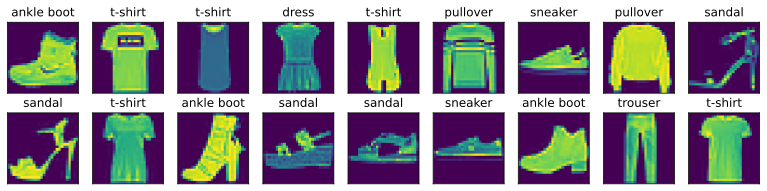

In [62]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [63]:
batch_size = 256

def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4


train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [64]:
timer = d2l.Timer()

for X, y in train_iter:
    continue
    
f'{timer.stop():.2f} sec'

'2.40 sec'

In [71]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [66]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [67]:
import torch
from IPython import display
from d2l import torch as d2l

In [74]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


In [75]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [76]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [77]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

In [79]:
X = torch.normal(0, 1, (2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

tensor([[-0.4515,  1.2430, -1.3681,  1.1547,  1.8808],
        [-1.6750,  0.1487, -0.1865,  0.6439,  0.4132]])


(tensor([[0.0452, 0.2460, 0.0181, 0.2252, 0.4655],
         [0.0335, 0.2075, 0.1484, 0.3404, 0.2703]]),
 tensor([1.0000, 1.0000]))

In [80]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [81]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [82]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [83]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [84]:
accuracy(y_hat, y) / len(y)

0.5

In [86]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()      # 将模型设置为评估模式
    metric = Accumulator(2)     # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [88]:
evaluate_accuracy(net, test_iter)

0.0382

In [89]:
# Concise Implementation of Softmax Regression
import torch
from torch import nn
from d2l import torch as d2l

In [90]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [91]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [92]:
loss = nn.CrossEntropyLoss(reduction='none')

In [93]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [94]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

AttributeError: module 'd2l.torch' has no attribute 'train_ch3'